In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Įkeliam pradinius duomenis
data = pd.read_csv('../2 - Data/develop.csv')
target = 'Ins'

# Patikriname ir konvertuojame kategorinius stulpelius į skaitinius (One-Hot Encoding)
data = pd.get_dummies(data, drop_first=True)  # Automatiškai konvertuoja visus kategorinius stulpelius

# Sukuriame X (nepriklausomi kintamieji) ir y (taikinys) duomenis
X = data.drop(columns=[target])
y = data[target]

# Sukuriame polinominius ir sąveikos kintamuosius su PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Sukuriame naują DataFrame su polinominių savybių pavadinimais
feature_names = poly.get_feature_names_out(input_features=X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Pridėkite taikinį (target) prie polinominių kintamųjų DataFrame
X_poly_df[target] = y

# Padalijame į treniravimo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df.drop(columns=[target]), X_poly_df[target], test_size=0.2, random_state=1
)

# Sujungiame X ir y treniravimo ir testavimo rinkiniuose
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Pradedame H2O serverį su padidinta atmintimi
h2o.init(max_mem_size="14G")

# Konvertuojame treniravimo ir testavimo rinkinius į H2OFrame
train_h2o = h2o.H2OFrame(train_data)
test_h2o = h2o.H2OFrame(test_data)

# Konvertuojame taikinio kintamąjį į kategorinį (binarinė klasifikacija)
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

# Apibrėžiame nepriklausomus kintamuosius ir taikinį
x = train_h2o.columns  # Visi stulpeliai
x.remove(target)       # Pašaliname taikinį, kad liktų tik nepriklausomi kintamieji
y = target             # Taikinys

# Sukuriame ir treniruojame GBM modelį su kryžmine validacija (k=5)
gbm_model_poly = H2OGradientBoostingEstimator(
    ntrees=50,
    max_depth=5,
    seed=42,
    nfolds=5  # 5 kartų kryžminė validacija
)

# Treniruojame GBM modelį su treniravimo rinkiniu
gbm_model_poly.train(x=x, y=y, training_frame=train_h2o)

# Vertiname modelį su testavimo duomenimis
performance = gbm_model_poly.model_performance(test_data=test_h2o)
print("GBM Model AUC on Test Data:", performance.auc())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 22 mins
H2O_cluster_timezone:,Europe/Vilnius
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_zydrunasbautronis_shsl0k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.321 Gb
H2O_cluster_total_cores:,11
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/Users/zydrunasbautronis/Documents/KTU/202409 Vidiniu Verslo Duomenu Projektas/.venv/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [InvBal Branch_B19, InvBal Branch_B18, Branch_B16 Branch_B17, Branch_B16 Branch_B19, Branch_B16 Branch_B18, CCBal Branch_B19, InvBal Branch_B15, InvBal Branch_B14, Inv Branch_B14, Branch_B7 Branch_B9, Inv Branch_B15, Branch_B13 Branch_B14, Inv Branch_B18, Branch_B13 Branch_B15, Branch_B13 Branch_B16, Branch_B7 Branch_B8, Branch_B13 Branch_B17, Inv Branch_B19, Branch_B13 Branch_B18, Branch_B13 Branch_B19, CCBal Branch_B14, CCBal Branch_B18, CCBal Branch_B15, POS Branch_B18, POS Branch_B19, Branch_B14 Branch_B2, Branch_B14 Branch_B4, Branch_B14 Branch_B3, Branch_B14 Branch_B6, Branch_B14 Branch_B5, Branch_B14 Branch_B8, Branch_B14 Branch_B7, Branch_B14 Branch_B9, POS Branch_B14, POS Branch_B15, Branch_B12 Branch_B18, Branch_B12 Branch_B19, Branch_B12 Branch_B16, Branch_B19 Branch_B2, Bran

██████████████████████████████████████████████████████| (done) 100%
GBM Model AUC on Test Data: 0.8117561510765394


In [6]:
performance = gbm_model.model_performance(test_data=test_h2o)
print("GBM Model AUC on Test Data:", performance.auc())

performance = gbm_model.model_performance(test_data=train_h2o)
print("GBM Model AUC on Train Data:", performance.auc())

cv_summary = gbm_model.cross_validation_metrics_summary()
print(cv_summary)

GBM Model AUC on Test Data: 0.8117561510765394
GBM Model AUC on Train Data: 0.83832321764656
Cross-Validation Metrics Summary: 
                         mean        sd            cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  ----------  ------------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.7170609   0.014636868   0.7013566     0.7011201     0.72438365    0.7273778     0.73106647
aic                      nan         0.0           nan           nan           nan           nan           nan
auc                      0.80269206  0.004356083   0.79629105    0.8056175     0.8017865     0.8020583     0.8077069
err                      0.2829391   0.014636868   0.2986434     0.29887995    0.27561632    0.27262226    0.26893353
err_count                1460.2      66.48834      1541.0        1521.0        1431.0        1416.0        1392.0
f0point5                 0.60270345  0.01442646    0.590

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_model_python_1729174575802_1748

,0,1,Error,Rate
0,3273.0,1017.0,0.2371,(1017.0/4290.0)
1,608.0,1555.0,0.2811,(608.0/2163.0)
Total,3881.0,2572.0,0.2518,(1625.0/6453.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

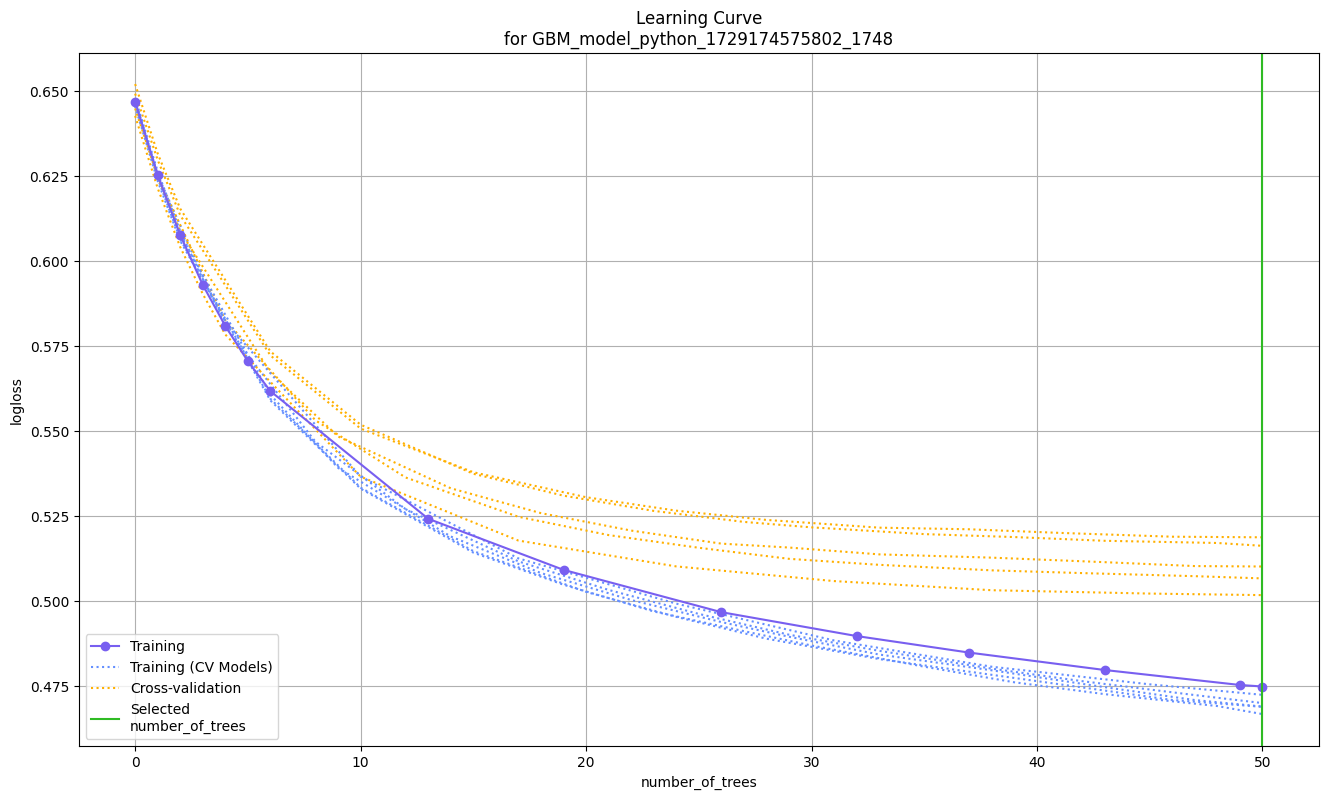

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

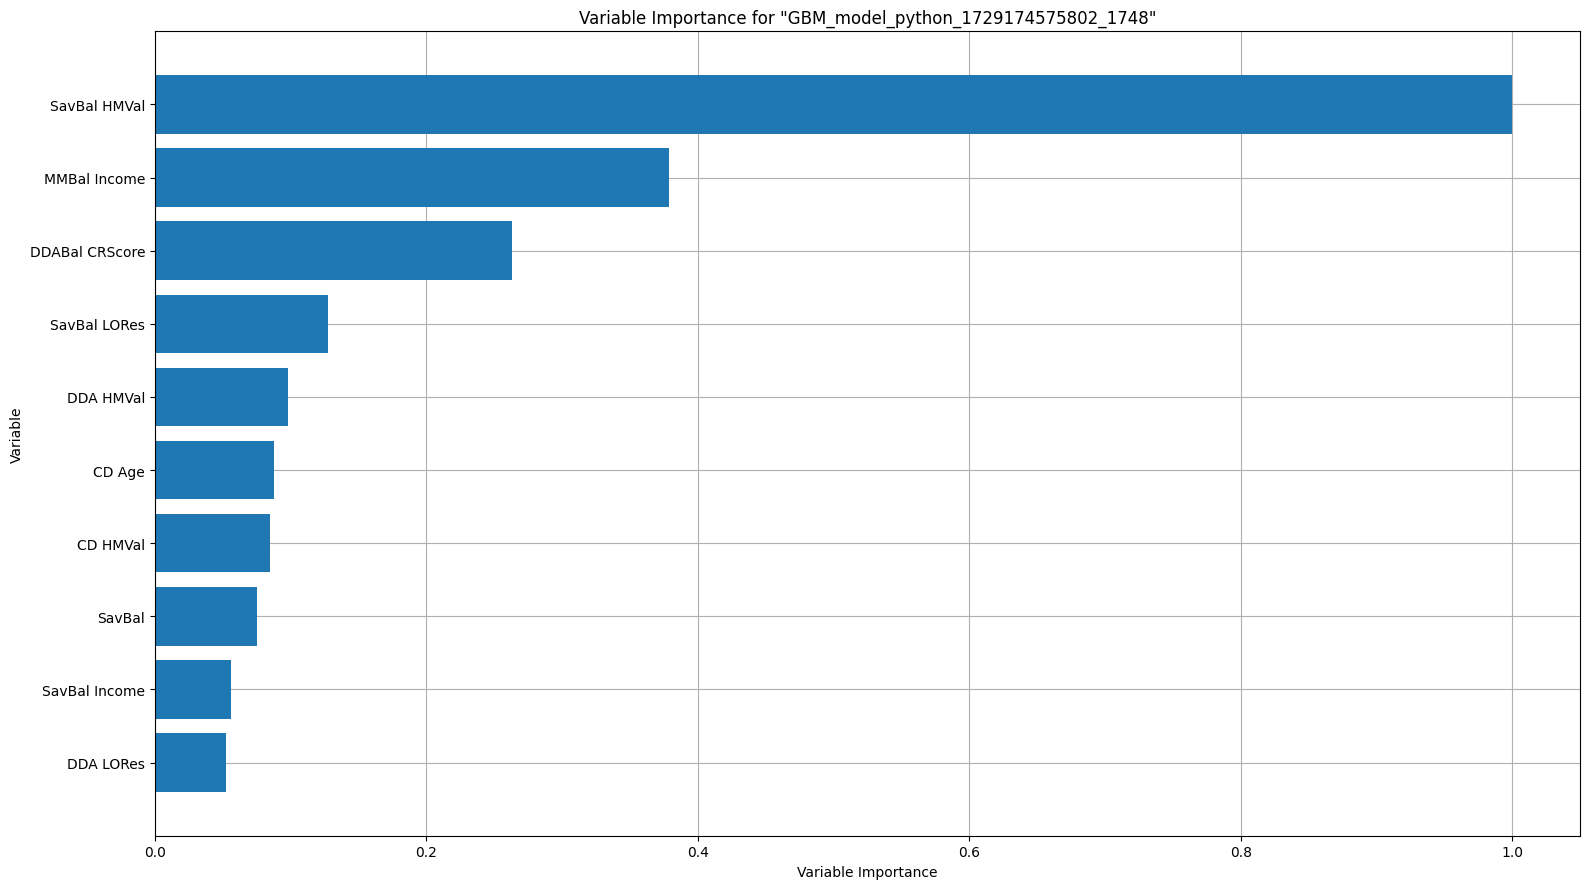

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

KeyboardInterrupt: 

In [7]:
h2o.explain(gbm_model, test_h2o)

# Paaiškinkite konkretų įrašą
h2o.explain_row(gbm_model, test_h2o, row_index=0)

### FEATURES + SMOTE

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from imblearn.over_sampling import SMOTE  # Import SMOTE
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Load initial data
data = pd.read_csv('../2 - Data/develop.csv')
target = 'Ins'

# Convert categorical columns to numerical (One-Hot Encoding)
data = pd.get_dummies(data, drop_first=True)

# Create X (features) and y (target)
X = data.drop(columns=[target])
y = data[target]

# Create polynomial and interaction features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Create a new DataFrame with polynomial feature names
feature_names = poly.get_feature_names_out(input_features=X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Add the target column to the polynomial features DataFrame
X_poly_df[target] = y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df.drop(columns=[target]), X_poly_df[target], test_size=0.2, random_state=1
)

# Apply SMOTE to the training set to balance the classes
smote = SMOTE(random_state=1)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Combine X and y for SMOTE-balanced training data
train_data = pd.concat([pd.DataFrame(X_train_smote, columns=X_train.columns), y_train_smote], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Initialize H2O with increased memory
h2o.init(max_mem_size="14G")

# Convert training and testing sets to H2OFrame
train_h2o = h2o.H2OFrame(train_data)
test_h2o = h2o.H2OFrame(test_data)

# Convert the target variable to categorical for binary classification
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

# Define predictors and target
x = train_h2o.columns
x.remove(target)  # Remove target to get only predictors
y = target        # Define target

# Initialize and train the GBM model with cross-validation (k=5)
gbm_model_smote_feature = H2OGradientBoostingEstimator(
    ntrees=10,
    max_depth=5,
    seed=42,
    nfolds=5  # 5-fold cross-validation
)

# Train GBM model with SMOTE-balanced training data
gbm_model_smote_feature.train(x=x, y=y, training_frame=train_h2o)

# Evaluate the model on the test set
performance = gbm_model_smote_feature.model_performance(test_data=test_h2o)
print("GBM Model AUC on Test Data with SMOTE:", performance.auc())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 8 mins
H2O_cluster_timezone:,Europe/Vilnius
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_zydrunasbautronis_shsl0k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.446 Gb
H2O_cluster_total_cores:,11
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/Users/zydrunasbautronis/Documents/KTU/202409 Vidiniu Verslo Duomenu Projektas/.venv/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [InvBal Branch_B19, InvBal Branch_B18, Branch_B16 Branch_B17, Branch_B16 Branch_B19, Branch_B16 Branch_B18, CCBal Branch_B19, InvBal Branch_B15, InvBal Branch_B14, Inv Branch_B14, Branch_B7 Branch_B9, Inv Branch_B15, Branch_B13 Branch_B14, Inv Branch_B18, Branch_B13 Branch_B15, Branch_B13 Branch_B16, Branch_B7 Branch_B8, Branch_B13 Branch_B17, Inv Branch_B19, Branch_B13 Branch_B18, Branch_B13 Branch_B19, CCBal Branch_B14, CCBal Branch_B18, CCBal Branch_B15, POS Branch_B18, POS Branch_B19, Branch_B14 Branch_B2, Branch_B14 Branch_B4, Branch_B14 Branch_B3, Branch_B14 Branch_B6, Branch_B14 Branch_B5, Branch_B14 Branch_B8, Branch_B14 Branch_B7, Branch_B14 Branch_B9, POS Branch_B14, POS Branch_B15, Branch_B12 Branch_B18, Branch_B12 Branch_B19, Branch_B12 Branch_B16, Branch_B19 Branch_B2, Bran

██████████████████████████████████████████████████████| (done) 100%
GBM Model AUC on Test Data with SMOTE: 0.8092342932148758


In [2]:
performance = gbm_model_smote_feature.model_performance(test_data=test_h2o)
print("GBM Model AUC on Test Data:", performance.auc())

performance = gbm_model_smote_feature.model_performance(test_data=train_h2o)
print("GBM Model AUC on Train Data:", performance.auc())

cv_summary = gbm_model_smote_feature.cross_validation_metrics_summary()
print(cv_summary)

GBM Model AUC on Test Data: 0.8092342932148758
GBM Model AUC on Train Data: 0.9033008255542723
Cross-Validation Metrics Summary: 
                         mean        sd            cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
-----------------------  ----------  ------------  ------------  ------------  ------------  ------------  ------------
accuracy                 0.79722947  0.0040907883  0.79362243    0.79771906    0.8031035     0.79862463    0.7930777
aic                      nan         0.0           nan           nan           nan           nan           nan
auc                      0.88668066  0.0032059923  0.88156044    0.8876315     0.88867396    0.8858127     0.88972473
err                      0.20277053  0.0040907883  0.2063776     0.20228091    0.19689651    0.2013754     0.20692228
err_count                1362.4      21.5824       1385.0        1348.0        1345.0        1347.0        1387.0
f0point5                 0.7879014   0.009041959   0.7

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## GBM_model_python_1729174575802_1572

,0,1,Error,Rate
0,2940.0,1350.0,0.3147,(1350.0/4290.0)
1,438.0,1725.0,0.2025,(438.0/2163.0)
Total,3378.0,3075.0,0.2771,(1788.0/6453.0)


# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

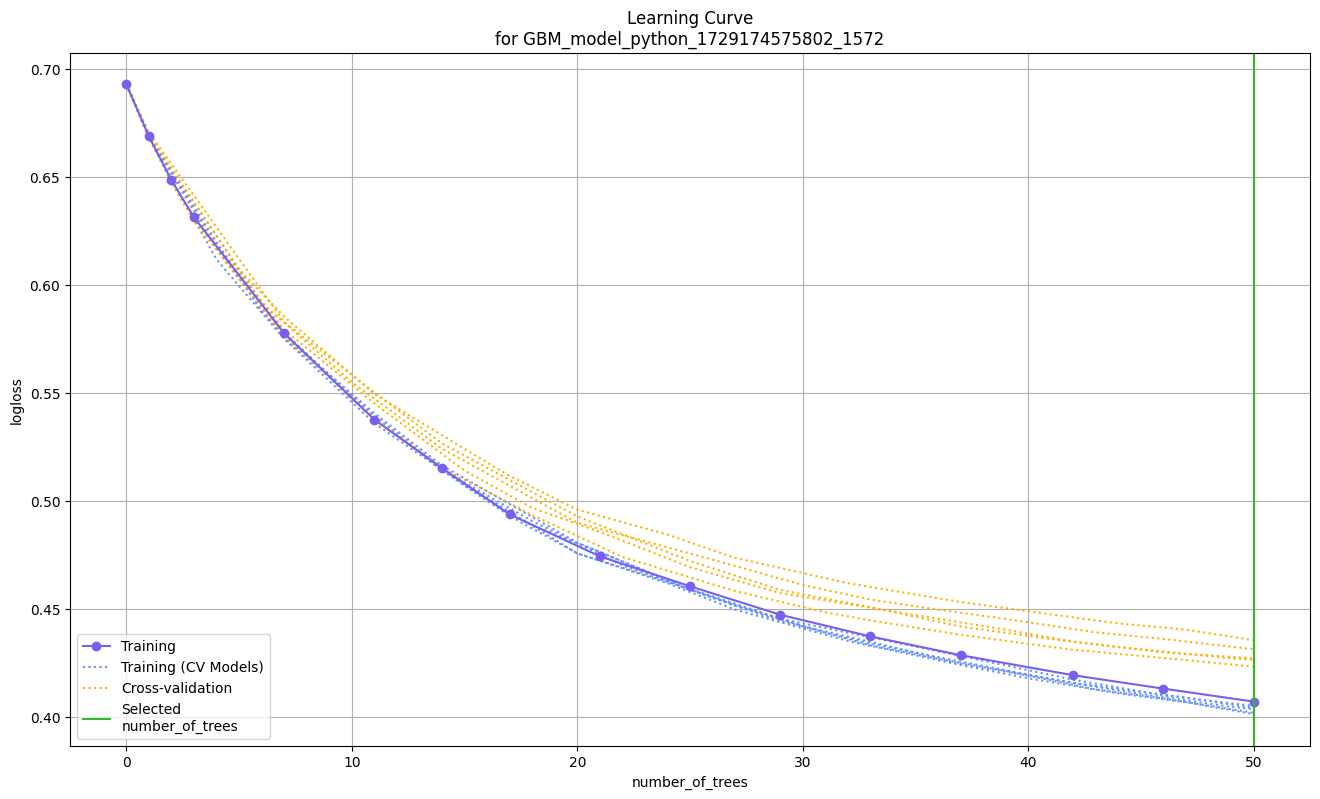

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

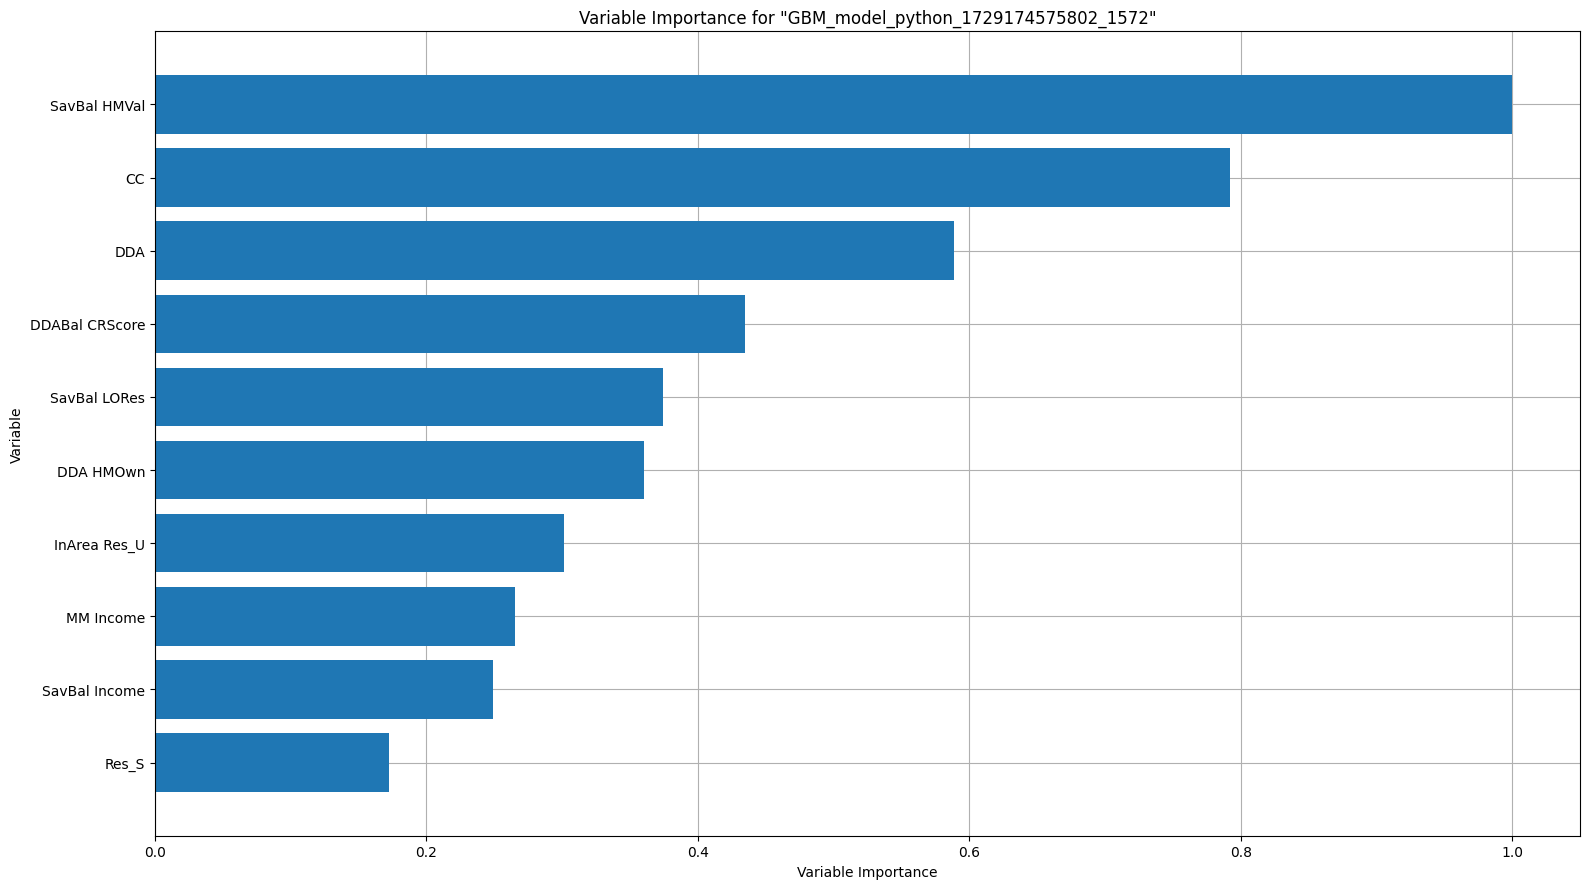

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

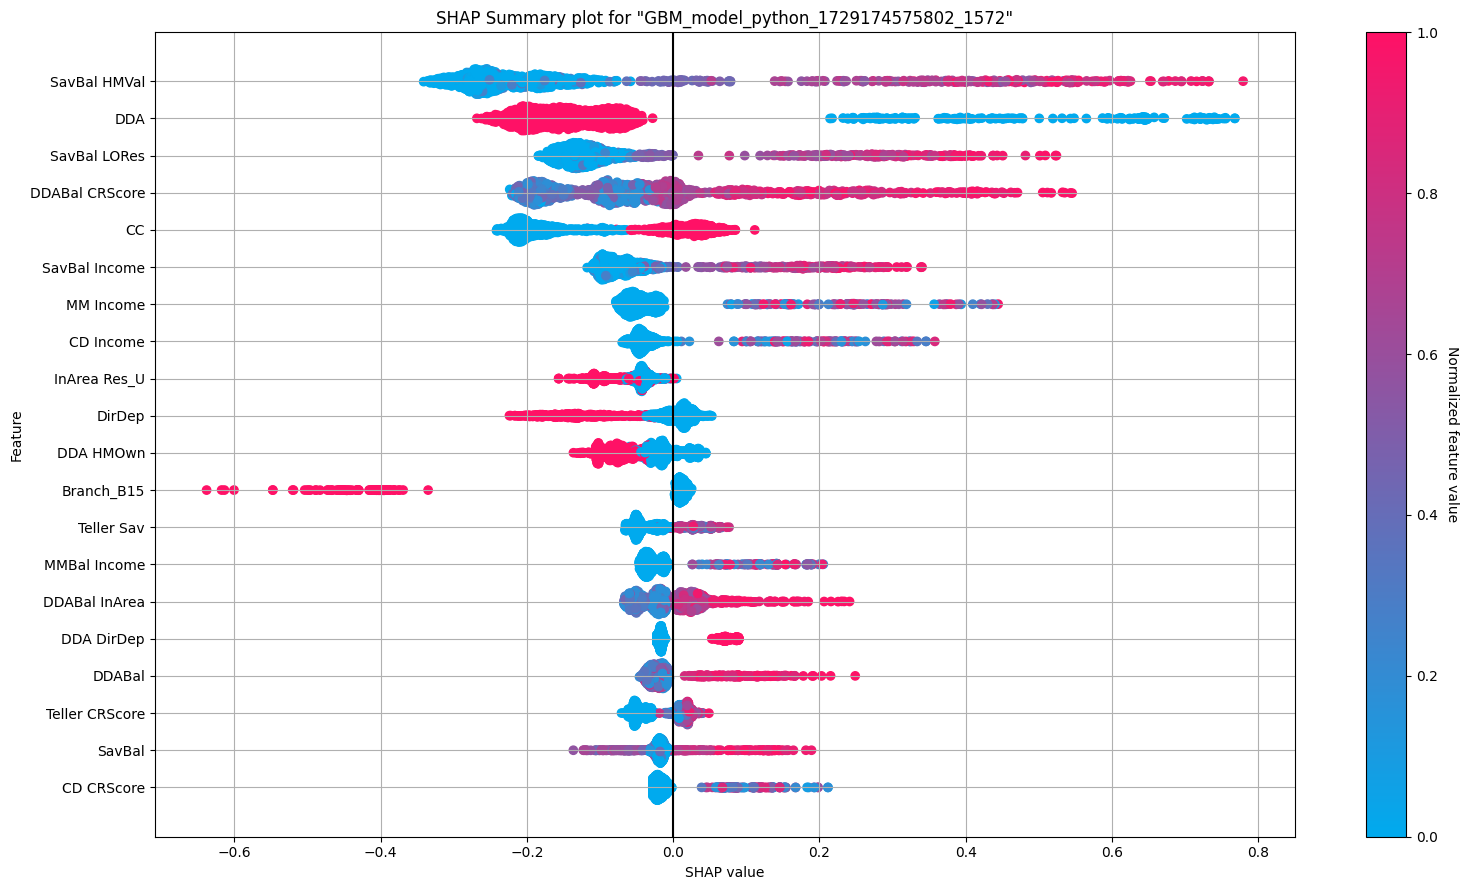

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

/Users/zydrunasbautronis/Documents/KTU/202409 Vidiniu Verslo Duomenu Projektas/.venv/lib/python3.12/site-packages/h2o/model/model_base.py:907: SyntaxWarning: invalid escape sequence '\s'
  """


H2OJobCancelled: Job<$03017f00000132d4ffffffff$_98136b1c3373594358655f34c338445e> was cancelled by the user.

<Figure size 1600x900 with 0 Axes>

In [8]:
h2o.explain(gbm_model_smote_feature, test_h2o)

# Paaiškinkite konkretų įrašą
h2o.explain_row(gbm_model_smote_feature, test_h2o, row_index=0)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator

# Įkeliam pradinius duomenis
data = pd.read_csv('../2 - Data/develop.csv')
target = 'Ins'

# Patikriname ir konvertuojame kategorinius stulpelius į skaitinius (One-Hot Encoding)
data = pd.get_dummies(data, drop_first=True)  # Automatiškai konvertuoja visus kategorinius stulpelius

# Sukuriame X (nepriklausomi kintamieji) ir y (taikinys) duomenis
X = data.drop(columns=[target])
y = data[target]

# Sukuriame polinominius ir sąveikos kintamuosius su PolynomialFeatures
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)

# Sukuriame naują DataFrame su polinominių savybių pavadinimais
feature_names = poly.get_feature_names_out(input_features=X.columns)
X_poly_df = pd.DataFrame(X_poly, columns=feature_names)

# Pridėkite taikinį (target) prie polinominių kintamųjų DataFrame
X_poly_df[target] = y

# Padalijame į treniravimo ir testavimo rinkinius
X_train, X_test, y_train, y_test = train_test_split(
    X_poly_df.drop(columns=[target]), X_poly_df[target], test_size=0.2, random_state=1
)

# Sujungiame X ir y treniravimo ir testavimo rinkiniuose
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# Pradedame H2O serverį su padidinta atmintimi
h2o.init(max_mem_size="14G")

# Konvertuojame treniravimo ir testavimo rinkinius į H2OFrame
train_h2o = h2o.H2OFrame(train_data)
test_h2o = h2o.H2OFrame(test_data)

# Konvertuojame taikinio kintamąjį į kategorinį (binarinė klasifikacija)
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

# Apibrėžiame nepriklausomus kintamuosius ir taikinį
x = train_h2o.columns  # Visi stulpeliai
x.remove(target)       # Pašaliname taikinį, kad liktų tik nepriklausomi kintamieji
y = target             # Taikinys

# Sukuriame ir treniruojame GBM modelį su kryžmine validacija (k=5)
gbm_model_new = H2OGradientBoostingEstimator(
    ntrees=10,
    max_depth=4,
    seed=42,
    nfolds=5  # 5 kartų kryžminė validacija
)

# Treniruojame GBM modelį su treniravimo rinkiniu
gbm_model_new.train(x=x, y=y, training_frame=train_h2o)

# Vertiname modelį su testavimo duomenimis
performance = gbm_model_new.model_performance(test_data=test_h2o)
print("GBM Model AUC on Test Data:", performance.auc())

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,3 hours 32 mins
H2O_cluster_timezone:,Europe/Vilnius
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.5
H2O_cluster_version_age:,1 month and 18 days
H2O_cluster_name:,H2O_from_python_zydrunasbautronis_shsl0k
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,6.284 Gb
H2O_cluster_total_cores:,11
H2O_cluster_allowed_cores:,11
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
gbm Model Build progress: |

/Users/zydrunasbautronis/Documents/KTU/202409 Vidiniu Verslo Duomenu Projektas/.venv/lib/python3.12/site-packages/h2o/estimators/estimator_base.py:192: RuntimeWarning: Dropping bad and constant columns: [InvBal Branch_B19, InvBal Branch_B18, Branch_B16 Branch_B17, Branch_B16 Branch_B19, Branch_B16 Branch_B18, CCBal Branch_B19, InvBal Branch_B15, InvBal Branch_B14, Inv Branch_B14, Branch_B7 Branch_B9, Inv Branch_B15, Branch_B13 Branch_B14, Inv Branch_B18, Branch_B13 Branch_B15, Branch_B13 Branch_B16, Branch_B7 Branch_B8, Branch_B13 Branch_B17, Inv Branch_B19, Branch_B13 Branch_B18, Branch_B13 Branch_B19, CCBal Branch_B14, CCBal Branch_B18, CCBal Branch_B15, POS Branch_B18, POS Branch_B19, Branch_B14 Branch_B2, Branch_B14 Branch_B4, Branch_B14 Branch_B3, Branch_B14 Branch_B6, Branch_B14 Branch_B5, Branch_B14 Branch_B8, Branch_B14 Branch_B7, Branch_B14 Branch_B9, POS Branch_B14, POS Branch_B15, Branch_B12 Branch_B18, Branch_B12 Branch_B19, Branch_B12 Branch_B16, Branch_B19 Branch_B2, Bran

██████████████████████████████████████████████████████| (done) 100%
GBM Model AUC on Test Data: 0.7913972758632953
